## PART 3: Hyperparameters Tuning

In [1]:
import sys
import joblib

import sklearn
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
# Variables
smiles_column='Iso_SMILES' # SMILES to used to convert into RDKit molecules
drop_list=['BCUT2D_MWHI','BCUT2D_MWLOW','BCUT2D_CHGHI','BCUT2D_CHGLO','BCUT2D_LOGPHI','BCUT2D_LOGPLOW','BCUT2D_MRHI','BCUT2D_MRLOW']
parameters = {'n_estimators': [25, 50, 100, 200], 'max_features': (None, "sqrt", "log2"), 'max_depth': [5, 10, 20, None], 'max_samples': [0.25, 0.5, 0.75, None], 'min_samples_split': [2, 4, 6, 10]}
score='neg_root_mean_squared_error'
best_params={'n_estimators': [], 'max_features': [], 'max_depth': [], 'max_samples': [], 'min_samples_split': []}
# best_params={'n_estimators': [], 'max_features': [], 'max_depth': [], 'min_samples_split': []}
n=50

N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")

save=False

Number of physical cores: 4


In [3]:
data = pd.read_csv('chemoeffectors_descriptors.csv')
data.drop(drop_list, axis=1, inplace=True)
data.dropna(inplace=True, ignore_index=True)
X = data.drop(['Chemoeffectors','Response','SMILES','Iso_SMILES','RDKit_Mol'], axis=1)
X

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,10.372723,10.372723,0.566065,-1.354074,0.510676,11.750000,175.140,166.068,175.048072,68,...,0,0,0,0,0,0,0,0,0,0
1,10.231944,10.231944,0.470880,-1.238241,0.456349,12.200000,147.130,138.058,147.053158,58,...,0,0,0,0,0,0,0,0,0,0
2,9.519306,9.519306,0.069444,-0.835648,0.475392,8.166667,89.094,82.038,89.047678,36,...,0,0,0,0,0,0,0,0,0,0
3,10.102570,10.102570,0.026806,-1.087603,0.511406,12.454545,161.157,150.069,161.068808,64,...,0,0,0,0,0,0,0,0,0,0
4,9.619306,9.619306,0.142361,-0.982731,0.438481,8.714286,103.121,94.049,103.063329,42,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,5.159028,5.159028,0.775000,0.775000,0.464599,9.000000,88.154,76.058,88.100048,38,...,0,0,0,0,0,0,0,0,1,0
273,9.035909,9.035909,0.087083,-0.091878,0.544873,9.909091,153.181,142.093,153.078979,60,...,0,0,0,0,0,0,0,0,0,0
274,9.480602,9.480602,0.180178,-0.669907,0.510157,12.769231,183.207,170.103,183.089543,72,...,0,0,0,0,0,0,0,0,0,0
275,9.226852,9.226852,0.087515,-0.794907,0.472427,12.833333,169.180,158.092,169.073893,66,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Generate the output features
Y = data['Response'].replace({'attractant': int(1), 'none': int(0), 'repellent': int(-1)})
Y

C:\Users\kgr26424\AppData\Local\Temp\ipykernel_22048\909473152.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y = data['Response'].replace({'attractant': int(1), 'none': int(0), 'repellent': int(-1)})


0      1
1      1
2      0
3      0
4      0
      ..
272    0
273    1
274    0
275   -1
276    1
Name: Response, Length: 277, dtype: int64

In [5]:
for i in range(n):
    if i < 10:
        split=0.10   # 90-10 splitting
    elif 10 <= i < 20:
        split=0.25   # 75-25 splitting
    else:
        split=0.20   # 80-20 splitting    
    rand=random.randint(0,9999)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=split, random_state=rand)
    grid_search = GridSearchCV(RandomForestRegressor(),
                               n_jobs=N_CORES,
                               param_grid=parameters,
                               cv=3,
                               verbose=2)
    grid_search.fit(X_train, Y_train)
    for key in best_params:
        best_params[key].append(grid_search.best_params_[key])

Fitting 3 folds for each of 768 candidates, totalling 2304 fits
Fitting 3 folds for each of 768 candidates, totalling 2304 fits
Fitting 3 folds for each of 768 candidates, totalling 2304 fits
Fitting 3 folds for each of 768 candidates, totalling 2304 fits
Fitting 3 folds for each of 768 candidates, totalling 2304 fits
Fitting 3 folds for each of 768 candidates, totalling 2304 fits
Fitting 3 folds for each of 768 candidates, totalling 2304 fits
Fitting 3 folds for each of 768 candidates, totalling 2304 fits
Fitting 3 folds for each of 768 candidates, totalling 2304 fits
Fitting 3 folds for each of 768 candidates, totalling 2304 fits
Fitting 3 folds for each of 768 candidates, totalling 2304 fits
Fitting 3 folds for each of 768 candidates, totalling 2304 fits
Fitting 3 folds for each of 768 candidates, totalling 2304 fits
Fitting 3 folds for each of 768 candidates, totalling 2304 fits
Fitting 3 folds for each of 768 candidates, totalling 2304 fits
Fitting 3 folds for each of 768 candidat

In [6]:
results=pd.DataFrame(best_params)
results

,n_estimators,max_features,max_depth,max_samples,min_samples_split
0,50,log2,20.0,NaN,4
1,200,sqrt,10.0,NaN,4
2,25,sqrt,10.0,0.50,4
3,100,sqrt,NaN,NaN,4
4,50,sqrt,20.0,0.50,2
5,25,sqrt,20.0,NaN,4
6,50,sqrt,10.0,0.75,2
7,100,log2,10.0,0.75,4
8,25,log2,NaN,0.50,2
9,100,sqrt,NaN,NaN,10


In [7]:
results_str = results.copy()
for key in results_str:
    results_str[key] = results_str[key].astype(str)

C:\Users\kgr26424\AppData\Local\Temp\ipykernel_22048\2373741469.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


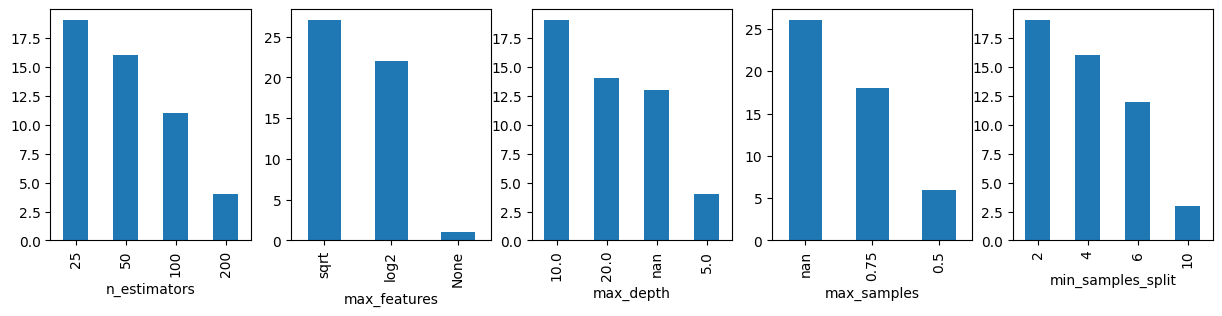

In [8]:
frequency = [results_str[key].value_counts() for key in results]
fig, axs = plt.subplots(1,len(frequency), figsize=(3*len(frequency), 3))
for i, ax in enumerate(axs):
    frequency[i].plot(kind='bar', ax=ax)
fig.show()

In [9]:
df = pd.DataFrame(grid_search.cv_results_)
if save:
    df.to_csv('hyperparameter_tuning.csv', index=False)